# Brute Force Collaborative Filtering

Notebook to perform brute force collaborative filtering on the LastFM dataset. 

### About the dataset
The data contains the complete music listening history of 992 users on LastFM over a span of several years, with a total of 19.1M records. Every song played by each of the users is available along with the timestamps. For this collaborative filtering exercise, we work with an aggregated version with only users and artists.

### Collaborative filtering methodology
We employ a user-user neighborhood based collaborative filtering. Since this is 
1. Split the data into training and testing data. Split is done by keeping a hold out (20%) of artists for every user.
2. Find the similarity between all pairs of users in the training data. Here we use Pearson Correlation for similarity, owing to it's ease of calculation using Pandas
3. Determine the peers of every user. We use a paraemeter k to determine the number of closest neighbors to consider. This parameter is tuned.
4. Calculate a weighted average of all music interests of the neighbors (weighted by the correlation to user). The values are mean centered. 
5. This weighted average is added to the average count of the user to get the counts in the test data

### Model Evaluation
We use Root Mean Squared Error (RMSE) and Mean Abbsolute Error (MAE) of the test predicitons to select our model parameters.



In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

## Read Data

In [30]:
data = pd.read_csv("./lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", 
                   delimiter="\t", header=None, 
                   names = ["userid","timestamp","musicbrainz-artist-id",
                            "artist-name","musicbrainz-track-id","track-name"])

In [31]:
print("Total number of rows:", len(data))
data.head(5)

Total number of rows: 19098862


,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


## Group data into artists and users

In [32]:
user_artist_groups = data.groupby(['userid','artist-name'])['timestamp'].count().reset_index()
user_artist_groups.columns = ['userid', 'artist-name', 'count']

In [33]:
user_artist_groups.head(5)

,userid,artist-name,count
0,user_000001,2562,26
1,user_000001,310,1
2,user_000001,3582,1
3,user_000001,4 Wings,2
4,user_000001,4Hero,146


In [34]:
user_artist_groups.tail(5)

,userid,artist-name,count
897416,user_001000,Zigmat,1
897417,user_001000,Zion I,2
897418,user_001000,Zy-,2
897419,user_001000,浜崎あゆみ,1
897420,user_001000,長沼英樹,18


### Save the file!

Let's save this grouped data into a csv for later use

In [35]:
user_artist_groups.to_csv("users_and_artists.csv", index=False)

In [36]:
unique_users = np.unique(user_artist_groups["userid"])
unique_artists = np.unique(user_artist_groups["artist-name"])

In [37]:
print('Number of unique users:', len(unique_users))
print('Number of unique artists:', len(unique_artists))

Number of unique users: 992
Number of unique artists: 173923


## Making Train-Test splits

In [38]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [39]:
user_artist_groups = pd.read_csv("users_and_artists.csv")

In [40]:
for u in unique_users:
    user_u_all_data = user_artist_groups.loc[user_artist_groups["userid"]==u,:]
    user_u_train, user_u_test = train_test_split(user_u_all_data, test_size=0.20, random_state=42)
    train_data = train_data.append(user_u_train)
    test_data = test_data.append(user_u_test)

In [41]:
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

## Make the user-item matrix

In [42]:
count_matrix = pd.DataFrame(columns = unique_users, index=unique_artists)

### Fill up the values of the matrix

In [43]:
for index, row in train_data.iterrows():
    count_matrix.loc[row['artist-name'], row['userid']] = row['count']

In [44]:
count_matrix = count_matrix.astype(float)

In [45]:
count_matrix.to_csv("count_matrix.csv", index = True)

In [46]:
del data, user_artist_groups #cleaning up some RAM

In [47]:
user_corr_matrix = count_matrix.corr()

## Finding k most correlated users (nearest neighbors) for each user

In [48]:
user_corr_matrix.head(5)

,user_000001,user_000002,user_000003,user_000004,user_000005,user_000006,user_000007,user_000008,user_000009,user_000010,...,user_000991,user_000992,user_000993,user_000994,user_000995,user_000996,user_000997,user_000998,user_000999,user_001000
user_000001,1.000000,-0.057230,0.427027,0.267180,-0.081073,0.342353,-0.109686,-0.430294,0.181502,-0.366927,...,-0.093730,-0.071619,0.380880,-0.251751,-0.047091,0.184118,-1.000000,0.929310,-0.018227,0.486616
user_000002,-0.057230,1.000000,0.006609,-0.031759,0.103367,0.110244,-0.159582,-0.213852,-0.073812,-0.214448,...,-0.018367,-0.042882,0.136112,0.297763,0.029010,-0.028058,-0.069850,0.156928,0.001762,0.274594
user_000003,0.427027,0.006609,1.000000,0.224455,0.202054,-0.028400,-0.068726,0.520668,0.111141,-0.030965,...,0.104279,-0.053574,-0.070045,0.222945,0.045960,0.208109,-0.327386,0.221143,-0.004975,0.038799
user_000004,0.267180,-0.031759,0.224455,1.000000,0.054552,-0.044578,0.087069,-0.280795,-0.055148,0.115495,...,-0.028945,0.209526,0.239227,-0.013614,0.096783,0.760990,-0.017256,0.625875,-0.043685,0.295971
user_000005,-0.081073,0.103367,0.202054,0.054552,1.000000,-0.059106,-0.129849,-0.120712,-0.082940,-0.040968,...,-0.513507,-0.053357,0.535216,0.102244,0.049824,-0.051752,-1.000000,-0.153929,-0.137953,-0.169765


In [76]:
user_corr_matrix.to_csv("user_corr_matrix.csv")

### Visualizing peers

The graph below illustrates the correlation between different users. The users are the nodes and each edge represents a correlation above 95%. The plot was obtained using Gephy, a handy tool for visualizing graphs.

![Visualization of correlation between users](data/highly-correlated-users.png)


## Predict for test data

In [50]:
test_data = pd.read_csv("test_data.csv")

In [51]:
test_data.head(5)

,userid,artist-name,count
0,user_000001,Yanokami,42
1,user_000001,Jeff Beck,15
2,user_000001,Jonny Greenwood,2
3,user_000001,Björk,448
4,user_000001,Ken Ishii,13


In [52]:
def get_user_nearest_neighbor_list(k, corr_matrix, user):
    user_list = np.array(list(corr_matrix))
    user_correlations = np.array(corr_matrix.loc[user,:])
    nearest_neighbors_inds = np.argsort(user_correlations)[::-1]
    nearest_neighbors_inds = nearest_neighbors_inds[user_correlations[nearest_neighbors_inds] > 0]
    nearest_neighbors = user_list[nearest_neighbors_inds]
    nearest_neighbors = np.delete(nearest_neighbors, np.where(nearest_neighbors==user)[0])
    return nearest_neighbors[:k]

def find_means(count_matrix):
    user_list = list(count_matrix)
    means = count_matrix.mean()
    return means

def predict_test_recommendations(test_data, train_count_matrix, train_corr_matrix, n_neighbors):
    
    test_true_counts = np.array([]) # empty initialize ground truth
    test_predicted_counts = np.array([]) # empty initialize predictions
    test_prediction_table = pd.DataFrame() # empty initialize prediction table
    
    test_users = np.unique(np.array(test_data["userid"])) # get list of all user-ids in test data
    mean_counts_of_users = find_means(train_count_matrix) # :pandas series: series of mean artist counts for each user
    
    # Find peer set for each user and predict based on peers' tastes
    for user in test_users:
        mean_user_counts = np.int8(mean_counts_of_users[user]) # user's mean counts, for centering
        # get list of k nearest neighbors (peer set) for the user
        peers = get_user_nearest_neighbor_list(k=n_neighbors, 
                                               corr_matrix=train_corr_matrix,
                                               user=user)
        peers_artist_counts = train_count_matrix.loc[:,peers] # artist counts of the peer-set
        mean_counts_of_peers = mean_counts_of_users[peers]
        peers_corrs = pd.Series()

        for nn in peers:
            peers_corrs[nn] = user_corr_matrix.loc[user, nn]
            peers_artist_counts.loc[:,nn] -= mean_counts_of_peers[nn]
            peers_artist_counts.loc[:,nn] *= peers_corrs[nn]    

        user_count_predictions_all_artists = peers_artist_counts.sum(axis=1)/peers_corrs.sum()     
        user_test_data = test_data.loc[test_data["userid"]==user,:].loc[:,["artist-name","count"]]    
        user_test_data_series = pd.Series(data = np.array(user_test_data["count"]), index = np.array(user_test_data["artist-name"]))
        user_count_predictions_test_artists = user_count_predictions_all_artists[user_test_data_series.index]
        user_count_predictions_test_artists += mean_user_counts
        
        test_predicted_counts = np.append(test_predicted_counts,np.ravel(np.array(user_count_predictions_test_artists)))
        test_true_counts = np.append(test_true_counts,np.ravel(np.array(user_test_data["count"])))
        user_test_data["predicted-counts"] = np.ravel(np.array(user_count_predictions_test_artists))
        test_prediction_table = test_prediction_table.append(user_test_data)
    
    root_mean_sq_error = np.sqrt(MSE(test_true_counts[~np.isnan(test_predicted_counts)], 
                                     test_predicted_counts[~np.isnan(test_predicted_counts)]))
    mean_abs_error = MAE(test_true_counts[~np.isnan(test_predicted_counts)],
                         test_predicted_counts[~np.isnan(test_predicted_counts)])
    return test_prediction_table, root_mean_sq_error, mean_abs_error
    

In [53]:
#test_prediction_table, root_mean_sq_error, mean_abs_error = predict_test_recommendations(test_data,count_matrix, user_corr_matrix, 5)

In [55]:
k_values = [1, 2, 5, 10, 20, 50, 100]
#k_values = [1,2]
rmses = np.zeros(len(k_values))
maes = np.zeros(len(k_values))
for i, k in enumerate(k_values):
    _, rmses[i], maes[i] = predict_test_recommendations(test_data,count_matrix,user_corr_matrix, k)
    

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [119]:
_, rmse_150, mae_150 = predict_test_recommendations(test_data,count_matrix,user_corr_matrix, 150)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [121]:
mae_150

27.145790291061516

In [56]:
rmses

array([ 134.97368629,  112.2475338 ,  107.41827015,  104.62916437,
        103.54589095,  102.70109187,  102.38243414])

In [57]:
maes

array([ 27.34999315,  27.23264357,  27.26989643,  27.24318398,
        27.20770483,  27.13205555,  27.1335189 ])

In [107]:
metric_table = pd.DataFrame({'K':k_values, 'RMSE':rmses, 'MAE': maes})
metric_table

,K,MAE,RMSE
0,1,27.349993,134.973686
1,2,27.232644,112.247534
2,5,27.269896,107.418270
3,10,27.243184,104.629164
4,20,27.207705,103.545891
5,50,27.132056,102.701092
6,100,27.133519,102.382434


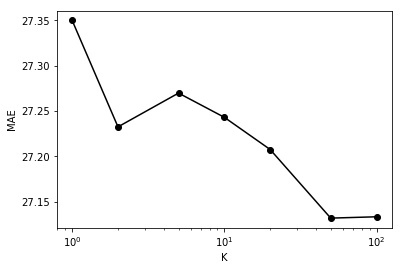

In [105]:
plt.plot(k_values, maes, '-ko')
plt.xscale('log')
plt.xlabel('K')
plt.ylabel('MAE')
plt.show()

In [115]:
def predict_baseline_recommendations(test_data, train_count_matrix):
    
    test_true_counts = np.array([]) # empty initialize ground truth
    test_predicted_counts = np.array([]) # empty initialize predictions
    test_prediction_table = pd.DataFrame() # empty initialize prediction table
    
    test_users = np.unique(np.array(test_data["userid"])) # get list of all user-ids in test data
    mean_counts_of_users = find_means(train_count_matrix) # :pandas series: series of mean artist counts for each user
    
    # Find peer set for each user and predict based on peers' tastes
    for user in test_users:
        mean_user_counts = np.int8(mean_counts_of_users[user]) # user's mean counts, for centering    
        user_test_data = test_data.loc[test_data["userid"]==user,:].loc[:,["artist-name","count"]]    
        user_test_data_series = pd.Series(data = np.array(user_test_data["count"]), index = np.array(user_test_data["artist-name"]))
        user_test_preds = mean_user_counts * np.ones(len(user_test_data))
        test_predicted_counts = np.append(test_predicted_counts,user_test_preds)
        test_true_counts = np.append(test_true_counts,np.ravel(np.array(user_test_data["count"])))
        user_test_data["predicted-counts"] = user_test_preds
        test_prediction_table = test_prediction_table.append(user_test_data)
    
    root_mean_sq_error = np.sqrt(MSE(test_true_counts[~np.isnan(test_predicted_counts)], 
                                     test_predicted_counts[~np.isnan(test_predicted_counts)]))
    mean_abs_error = MAE(test_true_counts[~np.isnan(test_predicted_counts)],
                         test_predicted_counts[~np.isnan(test_predicted_counts)])
    return test_prediction_table, root_mean_sq_error, mean_abs_error

In [116]:
_, baseline_rmse, baseline_mae = predict_baseline_recommendations(test_data,count_matrix)

In [117]:
baseline_rmse

102.98551732270417

In [118]:
baseline_mae

26.94809757833174

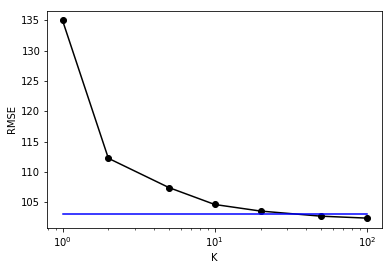

In [126]:
plt.plot(k_values, rmses, '-ko')
plt.plot(k_values, baseline_rmse* np.ones(len(rmses)), '-b')

plt.xscale('log')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()